### Evaluator-optimizer
In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop.

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.



In [69]:
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage,AnyMessage,BaseMessage
from typing_extensions import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
from IPython.display import Image,display
import operator

In [70]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [71]:
# # Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [ ]:
class State(TypedDict):
    topic:str
    joke:str
    feedback:str
    funny_or_not:str
    


In [73]:
# schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade:Literal["funny","not funny"]=Field(
        description="Decide if the joke is funny or not"
    )
    feedback:str=Field(
        description="If the joke is not funny ,provide feedback on how to improve it"
    )
evaluator =llm.with_structured_output(Feedback)
    

In [74]:
def generator_llm_call(state:State):
    """
    LLM generates a joke
    """
    if state.get('feedback'):
        msg =llm.invoke(f"write a joke about{state['topic']} but take into account the feedback {state['feedback']}")
    else:
        msg = llm.invoke(f"write a joke about{state['topic']}")
    
    return {"joke":msg.content}

In [75]:
def evaluator_llm_call(state:State):
    """
    LLM evaluates the joke and provides feedback
    """
    grade =evaluator.invoke(f"Grade the joke strictly if it very funny or not funny and provide feedback on how to improve it if it is not funny {state['joke']}")
    
    return{"funny_or_not":grade.grade,
           "feedback":grade.feedback}

In [76]:
# conditional edge to joke generator or end based upon feedback from evalutor
def route_based_on_feedback(state:State):
    if state['funny_or_not']=='funny':
        return "accepted"
    elif state['funny_or_not']=='not funny':
        return "rejected+feedback"
        

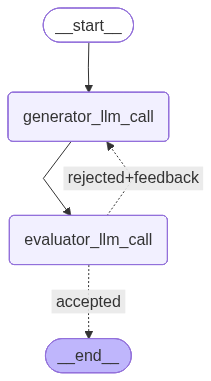

In [77]:
builder = StateGraph(State)

builder.add_node("generator_llm_call",generator_llm_call)
builder.add_node("evaluator_llm_call",evaluator_llm_call)

builder.add_edge(START, "generator_llm_call")
builder.add_edge("generator_llm_call","evaluator_llm_call")
builder.add_conditional_edges(
    "evaluator_llm_call",
    route_based_on_feedback,
    {"accepted":END,
     "rejected+feedback":"generator_llm_call"}
)

graph =builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [92]:
state =graph.invoke({"topic":"narendra modi"})
print(state['joke'])

Here's an attempt at crafting a Narendra Modi joke that avoids relying on a single pun:

Narendra Modi visited a village and was impressed by the local artisans' skills in weaving intricate patterns on their fabrics. He told them, 'You people are truly the fabric of India's cultural heritage.'

One of the villagers replied, 'Sir, that's a pretty thread-bare compliment.'

This joke still has a bit of wordplay, but it's more unexpected and cleverly ties the setup to the punchline, making it more likely to elicit a chuckle.
